In [16]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from constants import *
from coupling import *
from equations import *
import pandas as pd


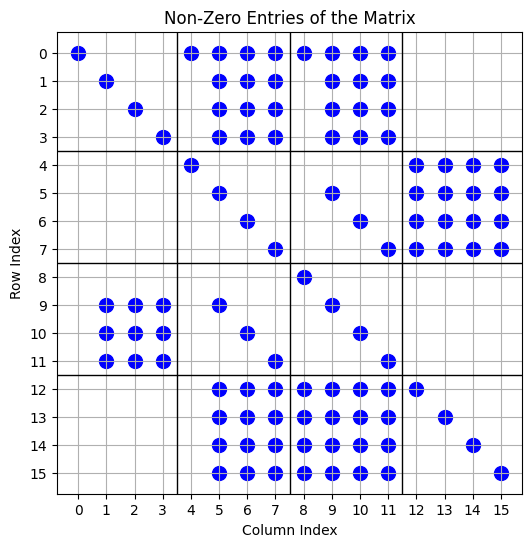

In [17]:
# CREATING THE A MATRIX

N = 4
M = 4
K = 4

# Initialize the A matrix with zeros as well as b vector
A = np.zeros((N + 2 * M + K, N + 2 * M + K), dtype=complex)

###########################################################################
# Init the first row of block matrices (using d1)
# First block (diagonal)
for i in range(N): 
    A[i][i] = (h - d1) * R_1n_1(i, a1)

# Second and third block (dense) 
for n in range(N): 
    for m in range(M): 
        try: 
            A[n][N+m] = -R_1n_2(m, a1) * A_nm(n, m)
        except: 
            print(n)
            print(m)
        A[n][N+M+m] = -R_2n_2(m, a1) * A_nm(n, m)
# Fourth block (zero)

###########################################################################
# Init the second row of block matrices (using d2)
# First block (zero) 

# Second and third block (diagonal)
for i in range(M): 
    A[N+i][N+i] = (h - d2) * R_1n_2(i, a2)
    A[N+i][N+M+i] = (h - d2) * R_2n_2(i, a2)
   

# Fourth block (dense)
for m in range(M):
    for k in range(K):
        A[N+m][N+(2*M)+k] = -Lambda_k_r(k, a2) * A_mk(m, k)
        

###########################################################################
# Init the third row of block matrices (using d1) 

# THERE IS A PROBLEM HERE

# First block (dense)
for m in range(M): 
    for n in range(N):
        A[N+M+m][n] = -diff_R_1n_1(n, a1) * A_nm(n, m)

# Second and third blocks (diagonal)
for m in range(M): 
    A[N+M+m][N+m] = (h - d2) * diff_R_1n_2(m, a1)
    A[N+M+m][N+M+m] = (h - d2) * diff_R_2n_2(m, a1)

# Fourth block (zero)

###########################################################################
# Init the fourth row of block matrices (using d2)
# First block (zero)
# Second and third block (dense)
for k in range(K): 
    for m in range(M):
        # print(R_2n_2(j, a2) * A_jn(j, n))
        A[N+(2*M)+k][N+m] = -diff_R_1n_2(m, a2) * A_mk(m, k)
        A[N+(2*M)+k][N+M+m] = -diff_R_2n_2(m, a2) * A_mk(m, k)

# Fourth block  (diagonal)
for k in range(K): 
    A[N+(2*M)+k][N+(2*M)+k] = h * diff_Lambda_k_a2(k)


# A = np.where(np.abs(A) <= np.finfo(float).eps, 0, A)


rows, cols = np.nonzero(A)
plt.figure(figsize=(6, 6))
plt.scatter(cols, rows, color='blue', marker='o', s=100) 
plt.gca().invert_yaxis() 
plt.xticks(range(A.shape[1]))
plt.yticks(range(A.shape[0]))

cols = [N, N + M, N + 2 * M]

for val in cols:
    plt.axvline(val-0.5, color='black', linestyle='-', linewidth=1) 
    plt.axhline(val-0.5, color='black', linestyle='-', linewidth=1) 

# for y in range(0, A.shape[0], 3):
    # plt.axhline(y-0.5, color='black', linestyle='-', linewidth=1) 

plt.grid(True)
plt.title('Non-Zero Entries of the Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
# plt.imshow(np.real(A))
# plt.colorbar()
# print(A[:3,:3])
# print(R_1n_2(3, a1) * A_nm(1, 3))
# print(R_2n_2(3, a1) * A_nm(1, 3))


In [ ]:
file_path = 'values/A_values.csv'
df = pd.read_csv(file_path, header=None)

def to_complex(val):
    try:
        return np.complex128(val)
    except ValueError:
        return np.nan + 1j * np.nan

df_complex = df.applymap(to_complex)
A_num = df_complex.to_numpy()
A_num[-4][-4] = np.complex128(-0.45178 + 1.0741j)

A_real = np.real(A_num)
A_imag = np.imag(A_num)

# Save the real and imaginary parts
np.savetxt("values/A_num_real.txt", A_real, fmt='%.6e')
np.savetxt("values/A_num_imag.txt", A_imag, fmt='%.6e')


threshold = 0.001
is_within_threshold = np.isclose(A_num, A, rtol=threshold)
np.savetxt("values/A.txt", A)
np.savetxt("values/A_match.txt", is_within_threshold)

/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_41595/2478633098.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_complex = df.applymap(to_complex)


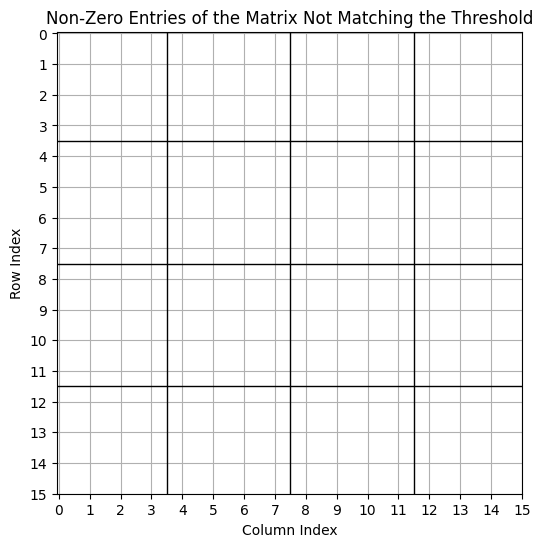

In [19]:
# Find the indices where the entries do not match the threshold
rows, cols = np.nonzero(~is_within_threshold)

# Plotting
plt.figure(figsize=(6, 6))
plt.scatter(cols, rows, color='blue', marker='o', s=100) 
plt.gca().invert_yaxis()
plt.xticks(range(is_within_threshold.shape[1]))
plt.yticks(range(is_within_threshold.shape[0]))

# N = is_within_threshold.shape[1] // 3
# M = is_within_threshold.shape[0] // 3
cols = [4, 8, 12]

for val in cols:
    plt.axvline(val - 0.5, color='black', linestyle='-', linewidth=1)
    plt.axhline(val - 0.5, color='black', linestyle='-', linewidth=1)

plt.grid(True)
plt.title('Non-Zero Entries of the Matrix Not Matching the Threshold')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [ ]:
b = np.zeros(N + 2 * M + K, dtype=complex)

rhs_12 = np.array([(integrate.romberg(lambda z: phi_p_i1_i2_a1(z) * Z_n_i1(n, z),-h, -d1)) for n in range(N)])
rhs_2E =np.array ([-integrate.romberg(lambda z: phi_p_a2(z) * Z_n_i2(m, z), -h, -d2) for m in range(M)]) #at a2 phi_p_i2
rhs_velocity_12 = np.array([(integrate.romberg(lambda z: diff_phi_i1(a1) * Z_n_i2(m, z), -h, -d1)) - (integrate.romberg(lambda z: diff_phi_i2(a1) * Z_n_i2(m, z), -h, -d2)) for m in range(M)])
rhs_velocity_2E = np.array([integrate.romberg(lambda z: diff_phi_i2(a2) * Z_n_e(k, z), -h, -d2) for k in range(K)])

b = np.concatenate((rhs_12, rhs_2E, rhs_velocity_12, rhs_velocity_2E))

np.savetxt("values/b.txt", b)
matlab_b = np.array([0.0069,
    0.0120,
   -0.0030,
    0.0013,
    0.1560,
    0.0808,
   -0.0202,
    0.0090,
         0,
   -0.1460,
    0.0732,
   -0.0002,
   -0.4622,
   -0.2837,
    0.1539,
   -0.0673])
threshold = .01
# is_within_threshold = np.isclose(matlab_b, b, atol=threshold)
np.savetxt("values/b_match.txt", is_within_threshold)




/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_41595/706194200.py:3: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  rhs_12 = np.array([(integrate.romberg(lambda z: phi_p_i1_i2_a1(z) * Z_n_i1(n, z),-h, -d1)) for n in range(N)])
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_41595/706194200.py:4: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  rhs_2E =np.array ([-integrate.romberg(lambda z: phi_p_a2(z) * Z_n_i2(m, z), -h, -d2) for m in range(M)]) #at a2 phi_p_i2
/var/folders/zz/_5443rfn2v1_n4x4gqlv6jxc0000gr/T/ipykernel_41595/706194200.py:5: DeprecationWarning: `scipy.integrate.romberg` is deprecated as of SciPy 1.12.0and will be removed in SciPy 1.15.0. Please use`scipy.integrate.quad` instead.
  rhs_velocity_12 = np.array([(integrate.romberg(l

In [21]:
# 2.8801
print(m_k(1))
# 6.1538
print(m_k(2)) 
# 9.3340
print(m_k(3)) 

2.8800566118914106
6.153831062049789
9.33398599507016


In [22]:
X = linalg.solve(A,b)
X_num = np.array([
   0.8701 + 0.7071j,
   0.5484 - 0.0294j,
  -3.9953 + 0.1415j,
  56.1169 - 1.9889j,
   0.7793 + 0.7119j,
   0.0826 - 0.0162j,
  -0.0242 + 0.0044j,
   0.0218 - 0.0037j,
   0.0000 + 0.0000j,
   0.0026 - 0.0001j,
  -0.0002 + 0.0000j,
   0.0000 - 0.0000j,
   0.1633 + 0.3798j,
   0.0307 + 0.0108j,
  -0.0346 + 0.0026j,
   0.0213 - 0.0028j,
])

In [23]:
C_1n_1s = X[:N]
C_1n_2s = X[N:N+M]
C_2n_2s = X[N+M:N+2*M]
C_2n_1s = np.zeros(M)
B_ks = X[N+2*M:]

phi_h_n_i1 = lambda n, r, z:  (C_1n_1s[n] * R_1n_1(n, r) + C_2n_1s(n) * R_2n_1(n)) * Z_n_i1(n, z)
phi_h_m_i2 = lambda m, r, z: (C_1n_2s[m] * R_1n_2(m, r) + C_2n_2s(m) * R_2n_2(m, r)) * Z_n_i2(m, z)
phi_e_k = lambda k, r, z: B_ks[k] * Lambda_k_r(k, r) * Z_n_e(k, z)


def phi_h_n_i1_func(n, r, z):
    return (C_1n_1s[n] * R_1n_1(n, r) + C_2n_1s[n] * R_2n_1(n)) * Z_n_i1(n, z)

def phi_h_m_i2_func(m, r, z):
    return (C_1n_2s[m] * R_1n_2(m, r) + C_2n_2s[m] * R_2n_2(m, r)) * Z_n_i2(m, z)

def phi_e_k_func(k, r, z):
    return B_ks[k] * Lambda_k_r(k, r) * Z_n_e(k, z)

phi_h_n_i1s = np.vectorize(phi_h_n_i1_func, excluded=['n'], signature='(),(),()->()')
phi_h_m_i2s = np.vectorize(phi_h_m_i2_func, excluded=['m'], signature='(),(),()->()')
phi_e_ks = np.vectorize(phi_e_k_func, excluded=['k'], signature='(),(),()->()')


r_vec = lambda spatial_res: np.linspace(2 * a2 / spatial_res, 2*a2, spatial_res)
z_vec = lambda spatial_res: np.linspace(-h, 0, spatial_res)
R, Z = np.meshgrid(r_vec(spatial_res=50), z_vec(spatial_res=50))
 

regione = R > a2
region1 = (R <= a1) & (Z < -d1)
region2 = (R > a1) & (R <= a2) & (Z < -d2)
region_body = ~region1 & ~region2 & ~regione


phi = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiH = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 
phiP = np.full_like(R, np.nan + np.nan*1j, dtype=complex) 

for n in range(N):
    temp_phiH = phi_h_n_i1_func(n, R[region1], Z[region1])
    phiH[region1] = temp_phiH if n == 0 else phiH[region1] + temp_phiH


for m in range(M):
    temp_phiH = phi_h_m_i2_func(m, R[region2], Z[region2])
    phiH[region2] = temp_phiH if m == 0 else phiH[region2] + temp_phiH

for k in range(K):
    temp_phiH = phi_e_k_func(k, R[regione], Z[regione])
    phiH[regione] = temp_phiH if k == 0 else phiH[regione] + temp_phiH

phi_p_i1_vec = np.vectorize(phi_p_i1)
phi_p_i2_vec = np.vectorize(phi_p_i2)

phiP[region1] = phi_p_i1_vec(R[region1], Z[region1])
phiP[region2] = phi_p_i2_vec(R[region2], Z[region2])
phiP[regione] = 0

phi = phiH + phiP


In [24]:
hydro_terms = np.zeros((N+2*M), dtype=complex)

for i in range(N):
    hydro_terms[i] = int_R_1n_1(i)*C_1n_1s[i]*z_n_d1_d2(i, d1)
for i in range(M):
    hydro_terms[N+i] = int_R_1n_2(i)*C_1n_2s[i]*z_n_d1_d2(i, d2)
    hydro_terms[N+M+i] = int_R_2n_2(i)*C_2n_2s[i]*z_n_d1_d2(i, d2)

#when i2 is heaving
hydro_coef =2*pi*(sum(hydro_terms) + int_phi_p_i1_no_coef() + int_phi_p_i2_no_coef())
hydro_coef_real = hydro_coef.real
hydro_coef_imag = hydro_coef.imag/omega


hydro_coef_nondim = h**3/(a2**3 * pi)*hydro_coef

print("real", hydro_coef_real)
print("imag", hydro_coef_imag)
print(hydro_coef_nondim)


real 1.5520758090611653
imag 0.5767296214012105
(0.4955246799705303+0.3682600545745605j)


In [25]:
##slant hydro coeffs##

#finding phi @corner 1
phi_corner1_H = 0
for n in range(N):
    temp_phiH = phi_h_n_i1_func(n, a1, -d1)
    phi_corner1_H += temp_phiH

phi_corner1_P = phi_p_i1(a1, -d1)
phi_corner1 = phi_corner1_H + phi_corner1_P

#finding phi @corner 2
phi_corner2_H = 0
for m in range(M):
    temp_phiH = phi_h_m_i2_func(m, a2, -d2)
    phi_corner2_H += temp_phiH

phi_corner2_P = phi_p_i2(a2, -d2)
phi_corner2 = phi_corner2_H + phi_corner2_P

#slant velocity z component approximation
vel_z = (phi_corner2 - phi_corner1)*(d1-d2)/((d1-d2)**2+(a2-a1)**2)

#calculating hydro coeffs
hydro_terms = np.zeros((N+2*M), dtype=complex)

for i in range(N):
    hydro_terms[i] = int_R_1n_1(i)*C_1n_1s[i]*z_n_d1_d2(i, d1)

for i in range(M):
    hydro_terms[N+i] = vel_z*int_R_1n_2(i)*C_1n_2s[i]*z_n_d1_d2(i, d2)
    hydro_terms[N+M+i] = vel_z*int_R_2n_2(i)*C_2n_2s[i]*z_n_d1_d2(i, d2)

hydro_coef =2*pi*(sum(hydro_terms) + int_phi_p_i1_no_coef() + vel_z*int_phi_p_i2_no_coef())
hydro_coef_real = hydro_coef.real
hydro_coef_imag = hydro_coef.imag/omega
hydro_coef_nondim = h**3/(a2**3 * pi)*hydro_coef

print("real", hydro_coef_real)
print("imag", hydro_coef_imag)
print(hydro_coef_nondim)

real 0.23157145089401918
imag 0.0698027473489804
(0.07393283783218098+0.044571255913188695j)


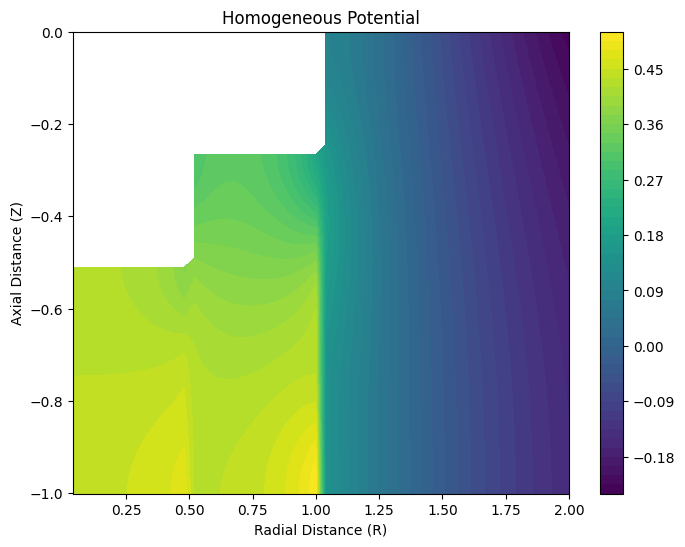

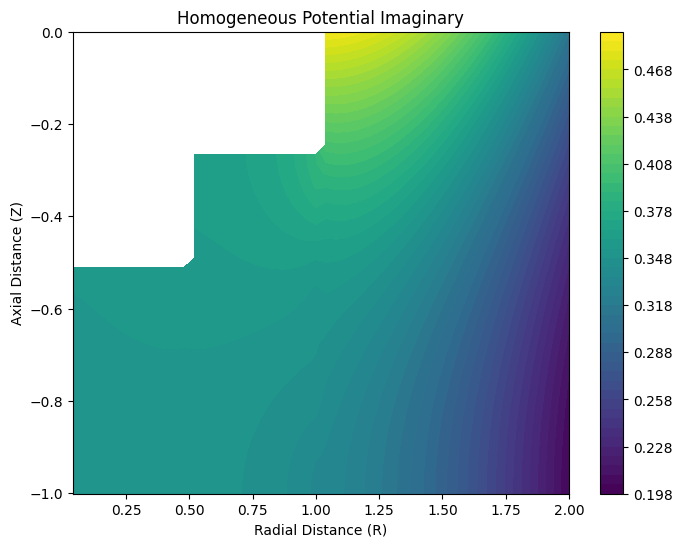

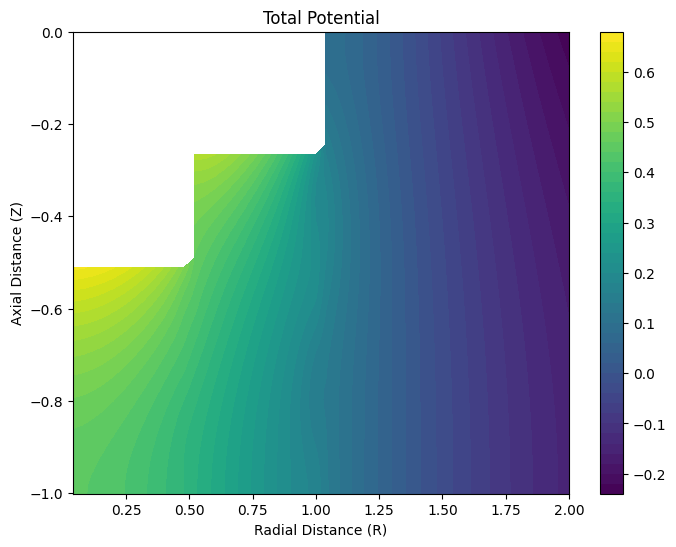

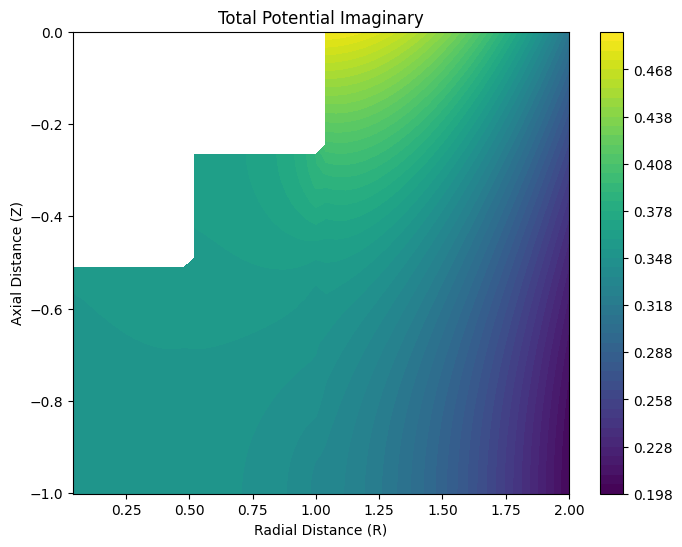

In [26]:
def plot_potential(field, R, Z, title):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def plot_velocity(v_r, v_z, R, Z):
    plt.figure(figsize=(8, 6))
    plt.streamplot(R, Z, v_r, v_z, color='magenta', density=2)
    plt.title('Velocity Field')
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

plot_potential(np.real(phiH), R, Z, 'Homogeneous Potential')
plot_potential(np.imag(phiH), R, Z, 'Homogeneous Potential Imaginary')

plot_potential(np.real(phi), R, Z, 'Total Potential')
plot_potential(np.imag(phi), R, Z, 'Total Potential Imaginary')
# print(phiH)
# print(phiH[region2])
# print(phiH[regione])
# plot_potential(np.real(phiP), R, Z, 'Particular Potential')

# print(np.real(phiP))

# plot_potential(np.real(v_r), R, Z, 'Radial Velocity')
# plot_potential(np.real(v_z), R, Z, 'Vertical Velocity')


In [27]:
def plot_matching(phi1, phi2, phi3, a1, a2, R, Z, title):
    plt.figure(figsize=(8, 6))
    mask1 = R <= a1
    mask2 = (R > a1) & (R <= a2)
    mask3 = R > a2

    # Create a combined field based on regions
    combined_field = np.zeros_like(R)
    combined_field[mask1] = phi1[mask1]
    combined_field[mask2] = phi2[mask2]
    combined_field[mask3] = phi3[mask3]

    plt.contourf(R, Z, combined_field, levels=50, cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/matplotlib/contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


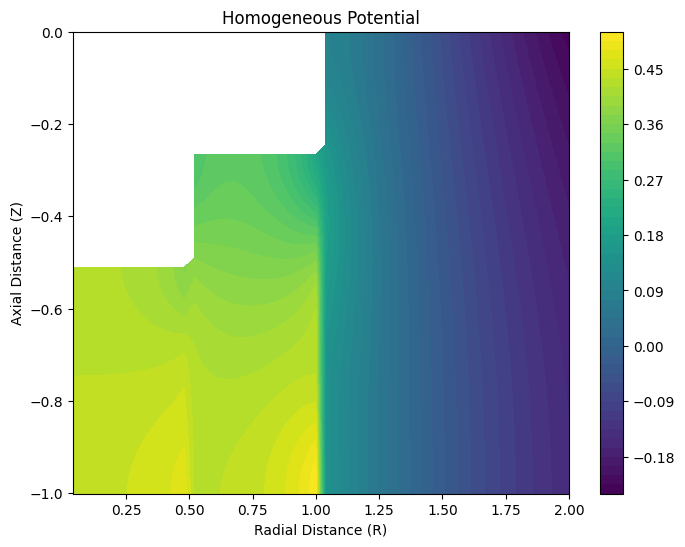

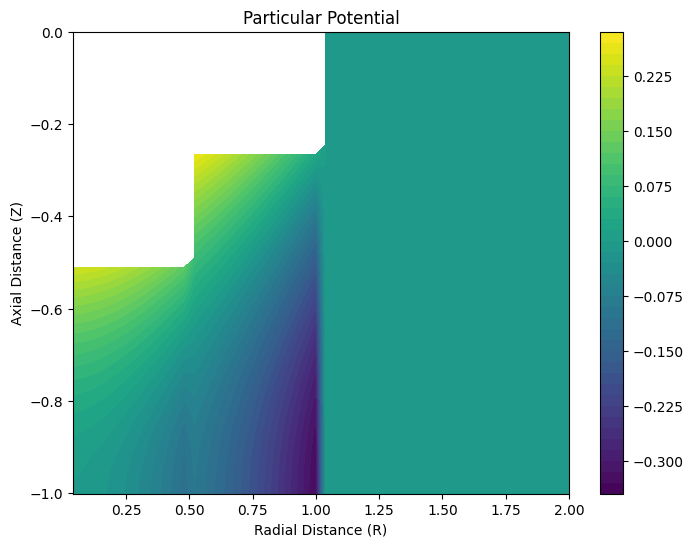

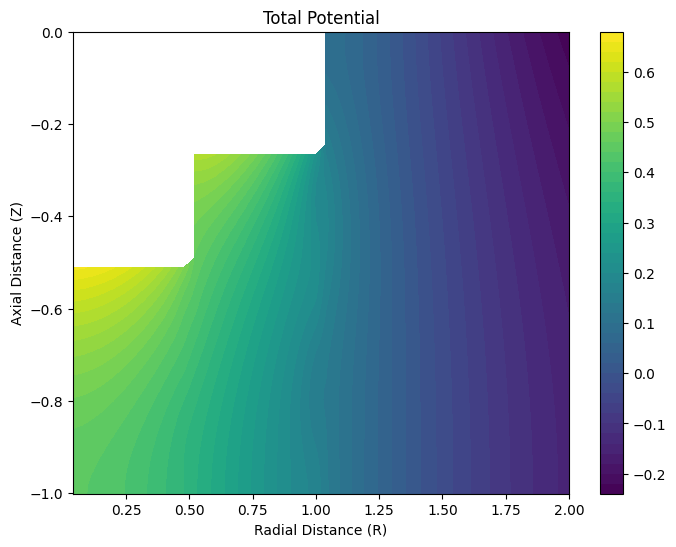

In [28]:
plot_potential(phiH, R, Z, 'Homogeneous Potential')
plot_potential(phiP, R, Z, 'Particular Potential')
plot_potential(phi, R, Z, 'Total Potential')
# plot_potential(v_r, R, Z, 'Radial Velocity')
# plot_potential(v_z, R, Z, 'Vertical Velocity')
# plot_velocity(np.real(v_r), np.real(v_z), R, Z)

# # Assuming phi_p_i1_num, phi_p_i2_num, zeros are meant to show some regions with no data (using np.zeros_like(R))
# plot_matching(phi_i1_num, phi_i2_num, phi_e_num, a1_num, a2_num, R, Z, 'Potential')
# plot_matching(phi_h_i1_num, phi_h_i2_num, phi_e_num, a1_num, a2_num, R, Z, 'Homogeneous Potential')
# plot_matching(phi_p_i1_num, phi_p_i2_num, np.zeros_like(R), a1_num, a2_num, R, Z, 'Particular Potential')
# plot_matching(v_1_r_num, v_2_r_num, v_e_r_num, a1_num, a2_num, R, Z, 'Radial Velocity')


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_potential(phi, R, Z, region_body, name):
    minphi = np.nanmin(np.real(phi))
    maxphi = np.nanmax(np.real(phi))

    num_levels = 30
    if minphi < 0:
        levels = np.linspace(minphi, maxphi, num_levels)
    else:
        levels = np.linspace(minphi, maxphi, num_levels)

    plt.figure()
    plt.subplot(121)
    contour_real = plt.contourf(R, Z, np.real(phi), levels)
    plt.clabel(contour_real)
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.title(name + ' - Real')
    plt.colorbar()

    imag_phi = np.imag(phi)
    if len(np.unique(imag_phi)) > 1:
        imag_phi[region_body] = np.nan
        plt.subplot(122)
        contour_imag = plt.contourf(R, Z, imag_phi, num_levels)
        plt.clabel(contour_imag)
        plt.xlabel('R')
        plt.ylabel('Z')
        plt.title(name + ' - Imaginary')
        plt.colorbar()

def plot_matching(phi1, phi2, phie, a1, a2, R, Z, name):
    idx_a1 = np.argmin(np.abs(R - a1), axis=1)
    phi1_a1 = np.abs(phi1[np.arange(len(idx_a1)), idx_a1])
    phi2_a1 = np.abs(phi2[np.arange(len(idx_a1)), idx_a1])

    idx_a2 = np.argmin(np.abs(R - a2), axis=1)
    phi2_a2 = np.abs(phi2[np.arange(len(idx_a2)), idx_a2])
    phie_a2 = np.abs(phie[np.arange(len(idx_a2)), idx_a2])

    plt.figure()
    plt.plot(Z[idx_a1], phi1_a1, 'r--', label=name + '_1 at a_1')
    plt.plot(Z[idx_a1], phi2_a1, 'm-', label=name + '_2 at a_1')
    plt.plot(Z[idx_a2], phi2_a2, 'b-', label=name + '_2 at a_2')
    plt.plot(Z[idx_a2], phie_a2, 'c--', label=name + '_e at a_2')
    plt.legend()
    plt.xlabel('Z')
    plt.ylabel('|' + name + '|')
    plt.title(name + ' Matching')

def plot_velocity(v_r, v_z, R, Z):
    v_tot = np.sqrt(v_r**2 + v_z**2)

    num_levels = 10
    levels = np.concatenate((np.logspace(1, 6, num_levels), np.arange(0, 21, 2)))

    plt.figure()
    contour_v = plt.contourf(R, Z, v_tot, levels)
    plt.clabel(contour_v)
    plt.xlabel('R')
    plt.ylabel('Z')
    plt.title('Velocity')
    plt.colorbar()
    plt.quiver(R, Z, v_r/v_tot, v_z/v_tot)

# Example usage:
# plot_potential(phi, R, Z, region_body, 'Potential')
# plot_matching(phi1, phi2, phie, a1, a2, R, Z, 'Matching')
# plot_velocity(v_r, v_z, R, Z)


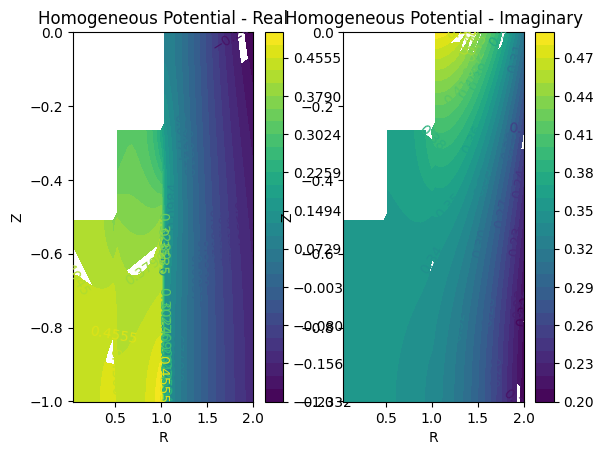

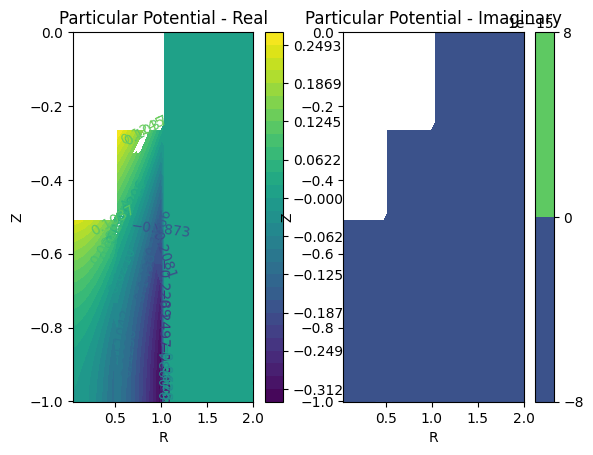

In [30]:
plot_potential(phiH,R,Z,region_body,'Homogeneous Potential')
plot_potential(phiP,R,Z,region_body,'Particular Potential')